In [1]:
# Core data handling and computation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import Counter
from functools import lru_cache
import gc
import logging
import warnings

# Text processing and NLP
import re
import spacy
import emoji
from spellchecker import SpellChecker
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from transformers import AutoTokenizer, AutoModel
import torch

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Topic modeling
from bertopic import BERTopic
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer

# Configure settings
warnings.filterwarnings("ignore")
tqdm.pandas() 
pd.set_option('display.max_columns', None) 

# I. Data collection

Data was mined using Instant Data Transfer on the evening of March 5, 2025. Once an X account was set-up, the top 20 recommnded travel accounts were followed and then the latest 10,000+ tweets were collected. 

In [2]:
# Create the dataframe
df = pd.read_csv('x.csv')

# Display basic info
#df.info()

# Verify the data
#df.head()

# II. Pre-processing

Given that the data was not done thru X official data scraping, some features needed to be dropped and pre-processed. 

In [3]:
# Keep necessary columns
columns_to_keep = [
    "css-175oi2r href",
    "css-1jxf684",
    "css-1jxf684 2",
    "css-146c3p1 href",
    "css-146c3p1",
    "css-1jxf684 4",
    "css-175oi2r href 4",
    "css-9pa8cd src 2",
    "css-1jxf684 5",
    "css-146c3p1 2",
    "css-146c3p1 href 2",
    "css-175oi2r href 5",
    "r-4qtqp9 src",
    "css-1jxf684 10",
    "css-1jxf684 11",
    "css-1jxf684 12",
    "css-1jxf684 14"

]

df_filtered = df[columns_to_keep]

# Map the kept columns
column_mapping = {
    "css-175oi2r href": "Tweet URL",
    "css-1jxf684": "Source Name",
    "css-1jxf684 2": "Source Handle",
    "css-146c3p1 href": "Tweet Status URL",
    "css-146c3p1": "Tweet Time Ago",
    "css-1jxf684 4": "Tweet Text",
    "css-175oi2r href 4": "Media URL",
    "css-9pa8cd src 2": "Image URL",
    "css-1jxf684 5": "Headline",
    "css-146c3p1 2": "Source URL",
    "css-146c3p1 href 2": "Analytics URL",
    "css-175oi2r href 5": "Emoji URL",
    "r-4qtqp9 src": "External Link",
    "css-1jxf684 10": "Replies",
    "css-1jxf684 11": "Views",
    "css-1jxf684 12": "Retweets",
    "css-1jxf684 14": "Likes"
}

# Keep necessary columns and create a copy
df_filtered = df[columns_to_keep].copy()

# Rename columns
df_filtered.rename(columns=column_mapping, inplace=True)

# Display updated column names
#df_filtered.info()


<Axes: >

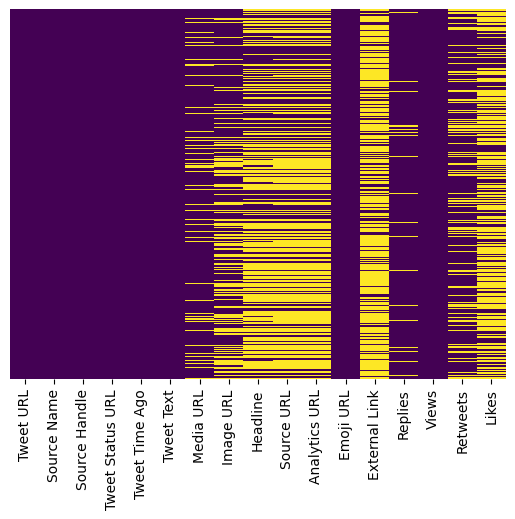

In [4]:
# Check null values 
df_filtered.isna().sum() 
sns.heatmap(df_filtered.isna(), yticklabels=False, cbar=False, cmap='viridis')

## A. Tweet date posting

In [5]:
# Convert Tweet Time Ago to datetime64 and adjust it to the mining date (March 5, evening)
def convert_tweet_time(tweet_time, reference_date=datetime(2025, 3, 6)):
    
    # Handle NaN/None values
    if pd.isna(tweet_time):
        return (None, "NaN value")
    
    # Convert to string and strip whitespace
    tweet_time = str(tweet_time).strip()
    
    # Skip empty strings
    if not tweet_time:
        return (None, "Empty string")
    
    try:
        # Handle relative times (seconds, minutes, hours)
        if 's' in tweet_time:
            seconds = int(tweet_time.replace('s', ''))
            return (reference_date - timedelta(seconds=seconds), None)
        elif 'm' in tweet_time:
            minutes = int(tweet_time.replace('m', ''))
            return (reference_date - timedelta(minutes=minutes), None)
        elif 'h' in tweet_time:
            hours = int(tweet_time.replace('h', ''))
            return (reference_date - timedelta(hours=hours), None)
        
        # Handle "Month Day, Year" format (like "Jul 31, 2024")
        if ',' in tweet_time:
            try:
                parsed_date = datetime.strptime(tweet_time, '%b %d, %Y')
                return (parsed_date, None)
            except ValueError:
                pass
        
        # Handle "Month Day" format (like "Mar 3")
        parts = tweet_time.split()
        if len(parts) == 2 and len(parts[0]) == 3 and parts[0].isalpha():
            month, day = parts
            try:
                date_str = f"{day}-{month}-{reference_date.year}"
                parsed_date = datetime.strptime(date_str, '%d-%b-%Y')
                if parsed_date <= reference_date:
                    return (parsed_date, None)
                else:
                    date_str = f"{day}-{month}-{reference_date.year-1}"
                    parsed_date = datetime.strptime(date_str, '%d-%b-%Y')
                    return (parsed_date, None)
            except ValueError as e:
                return (None, f"Month Day format error: {str(e)}")
        
        # Handle "Day-Month" format (like "4-Mar")
        elif '-' in tweet_time and len(tweet_time.split('-')) == 2:
            day, month = tweet_time.split('-')
            try:
                date_str = f"{day}-{month}-{reference_date.year}"
                parsed_date = datetime.strptime(date_str, '%d-%b-%Y')
                if parsed_date <= reference_date:
                    return (parsed_date, None)
                else:
                    date_str = f"{day}-{month}-{reference_date.year-1}"
                    parsed_date = datetime.strptime(date_str, '%d-%b-%Y')
                    return (parsed_date, None)
            except ValueError as e:
                return (None, f"Day-Month format error: {str(e)}")
        
        # Handle full dates (like "3-Jan-23")
        elif '-' in tweet_time and len(tweet_time.split('-')) == 3:
            try:
                if len(tweet_time.split('-')[2]) == 2:
                    parsed_date = datetime.strptime(tweet_time, '%d-%b-%y')
                else:
                    parsed_date = datetime.strptime(tweet_time, '%d-%b-%Y')
                return (parsed_date, None)
            except ValueError as e:
                return (None, f"Full date format error: {str(e)}")
    
    except Exception as e:
        return (None, f"Unexpected error: {str(e)}")
    
    # If format wasn't recognized
    return (None, "Unrecognized format")

# Apply conversion and track errors
conversion_results = df_filtered['Tweet Time Ago'].apply(
    lambda x: convert_tweet_time(x)
)

# Split results into separate columns
df_filtered['Tweet Datetime Posted'] = conversion_results.apply(lambda x: x[0])
df_filtered['conversion_error'] = conversion_results.apply(lambda x: x[1])  # Add this line to store errors

# Show entries that couldn't be converted before deleting them
failed_conversions = df_filtered[df_filtered['Tweet Datetime Posted'].isna()]
print(f"\nFailed to convert {len(failed_conversions)} entries:")
print(failed_conversions[['Tweet Time Ago', 'conversion_error']].to_string())

# Show conversion statistics
success_count = len(df_filtered) - len(failed_conversions)
print(f"\nConversion Summary:")
print(f"Successfully converted: {success_count}")
print(f"Failed to convert: {len(failed_conversions)}")
print(f"Success rate: {success_count/len(df_filtered):.1%}")

# Keep only rows where conversion was successful
df_filtered = df_filtered[df_filtered['Tweet Datetime Posted'].notna()]

# Verify the deletion
print(f"\nAfter deletion, dataframe has {len(df_filtered)} rows")

# Show sample of successful conversions
#print("\nSample of successful conversions:")
#print(df_filtered[['Tweet Time Ago', 'Tweet Datetime Posted']].head(10).to_string())

df_filtered.drop(['Tweet Time Ago', 'conversion_error'], axis=1, inplace=True)  


Failed to convert 13 entries:
                       Tweet Time Ago                                                                            conversion_error
730                               NaN                                                                                   NaN value
731    Click to Follow geoffreyfowler                                                                         Unrecognized format
732   Click to Follow DiscoverIreland  Unexpected error: invalid literal for int() with base 10: 'Click to Follow DicoverIreland'
733             Click to Follow Apple                                                                         Unrecognized format
734                               NaN                                                                                   NaN value
2924         Click to Follow awscloud         Unexpected error: invalid literal for int() with base 10: 'Click to Follow awcloud'
2925   Click to Follow flavourofitaly                      

## B. Engagement metrics

In [6]:
# Converts X engagement metrics' number formats (1.5K, 2,000)
for col in ['Replies', 'Views', 'Retweets', 'Likes']:
    df_filtered[col] = (
        df_filtered[col]
        .astype(str)
        .str.replace(',', '')
        .str.replace('K', 'e3', case=False)
        .str.replace('M', 'e6', case=False)
    )
    df_filtered[col] = (
        pd.to_numeric(df_filtered[col], errors='coerce')
        .fillna(0)
        .astype(int)
    )

# Spot-check random rows
#print(df_filtered[col].sample(5))          

## C. Duplicate rows


In [7]:
# Delete duplicate rows 
df_filtered = df_filtered.drop_duplicates()

## D. Tweet text

### 1. Special cases

In [8]:
# Count entires with hashtags
hashtag_count = df_filtered["Tweet Text"].str.contains(r"#\w+", regex=True, na=False).sum()

# Print the result
print(f"Number of tweets with hashtags: {hashtag_count}")

Number of tweets with hashtags: 4


### 2. Lowercase, special cases & spelling

Very few tweets have hashtags, proceeds to delete them along with URLs, mentions (@usernames), emojis, and special characters. Spelling is checked using Pyspellchecker, because it is lightweight (No need for external dictionaries like SymSpell) and works well for American & British English spelling. It doesn’t correct based on context like TextBlob, but is useful enough for correcting individual words in short text.

In [9]:
# Enable progress bars for pandas
tqdm.pandas()

# Clean tweet text
def clean_tweet(text):
    if pd.isna(text):
        return ""
    
    text = str(text).lower()                       # Convert to lowercase
    text = re.sub(r"http\S+|www\S+", "", text)     # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)          # Remove mentions & hashtags
    text = emoji.replace_emoji(text, replace="")   # Remove emojis
    text = re.sub(r"[^a-z0-9\s]", "", text)        # Remove special characters
    return text.strip()

# Efficient spelling correction using cached spellchecker
spell = SpellChecker()

@lru_cache(maxsize=20000)  # Cache corrections to avoid redundant lookups
def get_correction(word):
    return word if word in spell else spell.correction(word) or word

def correct_spelling(text):
    words = text.split()
    corrected = [get_correction(word) for word in words]
    return " ".join(corrected)

# Apply cleaning and correction with progress bars
df_filtered["Cleaned Tweet"] = df_filtered["Tweet Text"].progress_apply(clean_tweet)
df_filtered["Cleaned Tweet"] = df_filtered["Cleaned Tweet"].progress_apply(correct_spelling)

# Drop the original column
df_filtered.drop(columns=["Tweet Text"], inplace=True)

100%|██████████| 10031/10031 [11:08<00:00, 15.00it/s]


In [10]:
# Display pre-procecessed dataFrame
df_filtered.info()
#df_filtered.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 10031 entries, 0 to 10090
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Tweet URL              10031 non-null  object        
 1   Source Name            10031 non-null  object        
 2   Source Handle          10031 non-null  object        
 3   Tweet Status URL       10031 non-null  object        
 4   Media URL              8776 non-null   object        
 5   Image URL              6664 non-null   object        
 6   Headline               4436 non-null   object        
 7   Source URL             4148 non-null   object        
 8   Analytics URL          4131 non-null   object        
 9   Emoji URL              10031 non-null  object        
 10  External Link          2413 non-null   object        
 11  Replies                10031 non-null  int32         
 12  Views                  10031 non-null  int32         
 13  Retwee

# III. Analysis

## A. Entity Analysis

### 1. Hashtag 

Only 4 tweets have hashtags

### 2. Media & links

The majority of tweets that do not include any media, images, or external links still received high views and engagement.

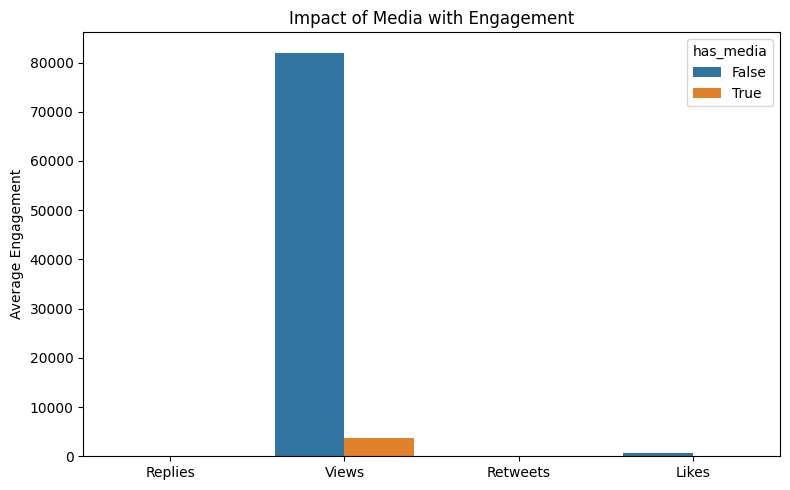

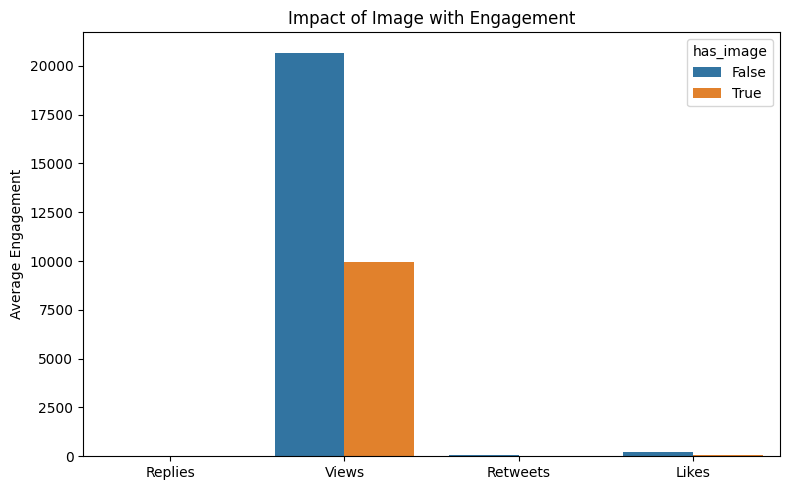

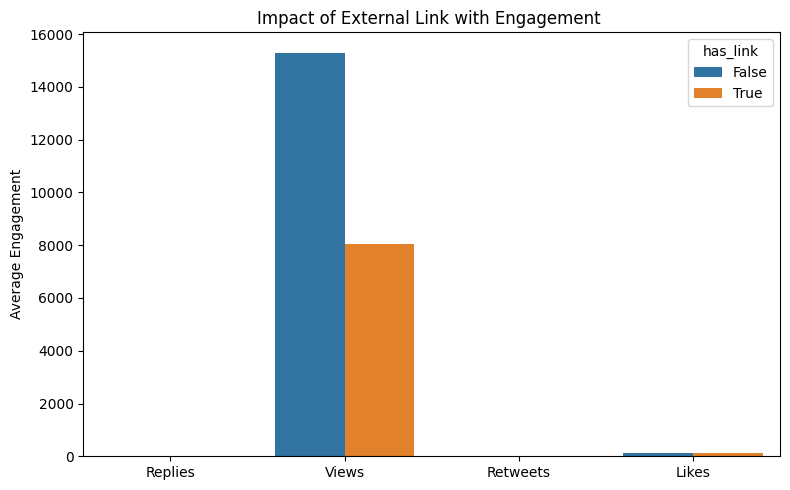

In [11]:
# Create flags for presence of media, image, and external links
df_filtered['has_media'] = df_filtered['Media URL'].notnull()
df_filtered['has_image'] = df_filtered['Image URL'].notnull()
df_filtered['has_link'] = df_filtered['External Link'].notnull()

# Grouped averages
media_stats = df_filtered.groupby('has_media')[['Replies', 'Views', 'Retweets', 'Likes']].mean().reset_index()
image_stats = df_filtered.groupby('has_image')[['Replies', 'Views', 'Retweets', 'Likes']].mean().reset_index()
link_stats = df_filtered.groupby('has_link')[['Replies', 'Views', 'Retweets', 'Likes']].mean().reset_index()

# Visualization
def plot_engagement(df, col, title):
    df_melted = df.melt(id_vars=col, var_name='Engagement Type', value_name='Average Count')
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_melted, x='Engagement Type', y='Average Count', hue=col)
    plt.title(title)
    plt.ylabel('Average Engagement')
    plt.xlabel('')
    plt.legend(title=col)
    plt.tight_layout()
    plt.show()

plot_engagement(media_stats, 'has_media', 'Impact of Media with Engagement')
plot_engagement(image_stats, 'has_image', 'Impact of Image with Engagement')
plot_engagement(link_stats, 'has_link', 'Impact of External Link with Engagement ')


### 3. Active users (based on number of Tweets)

Most handles belong to well-known travel media outlets (e.g., @CNTraveler, @TelegraphTravel, @TravelWeeklyUS, @NatGeoTravelLIK)  indicating that professional travel publishers are highly active on Twitter. These accounts may prioritize frequent updates to stay relevant or cover breaking travel news. 

The presence of travel guides/review platforms like (e.g., @Tripadvisor and @frommers) tweet less frequently than media outlets, possibly focusing on curated content over volume.

The absence of individual influencers suggests that institutions dominate high-volume tweeting in the travel niche.

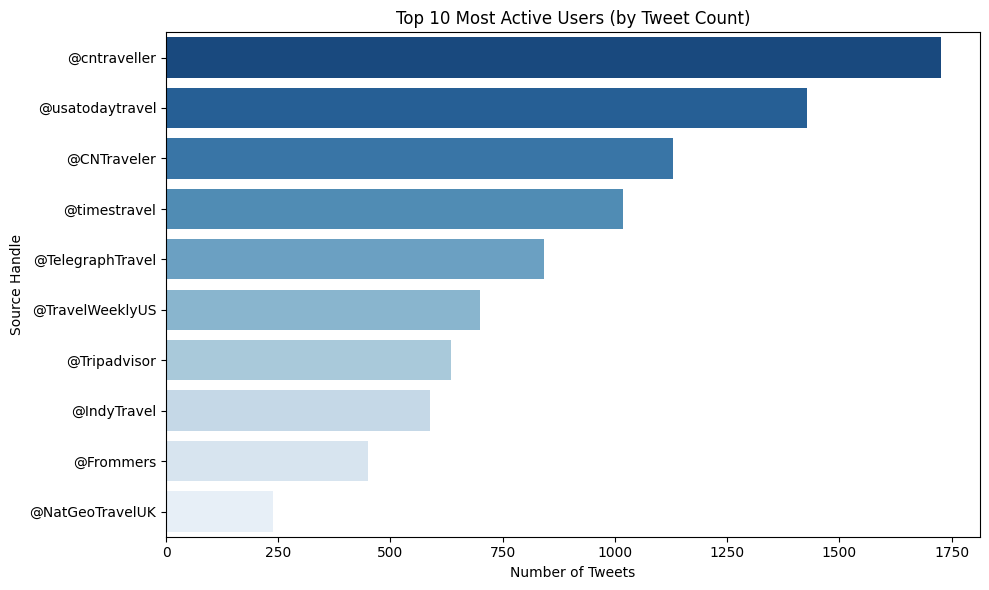

In [12]:
# Get the top 10 most active users by tweet count 
top_active = df_filtered['Source Handle'].value_counts().head(10)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=top_active.values, y=top_active.index, palette='Blues_r')
plt.title('Top 10 Most Active Users (by Tweet Count)')
plt.xlabel('Number of Tweets')
plt.ylabel('Source Handle')
plt.tight_layout()
plt.show()

### 4. Most engagement

Visibility vs. Engagement: High tweet counts don't necessarily correlate with high engagement.

Media Brands (e.g., @Cntraveller, @usatodaytravel) focus on tweet volume and replies, but lack viral reach.

Individual Influencers (e.g., @Rainmaker1973, @TravelAndLove) excel in passive engagement (views/likes) and shares, which may mean that their content is optimized for algorithms.

@PeteButtigieg (a public figure) leads in Replies and is in the top 10 of other metrics, shows that his account drives discussions but may not attract casual viewers.

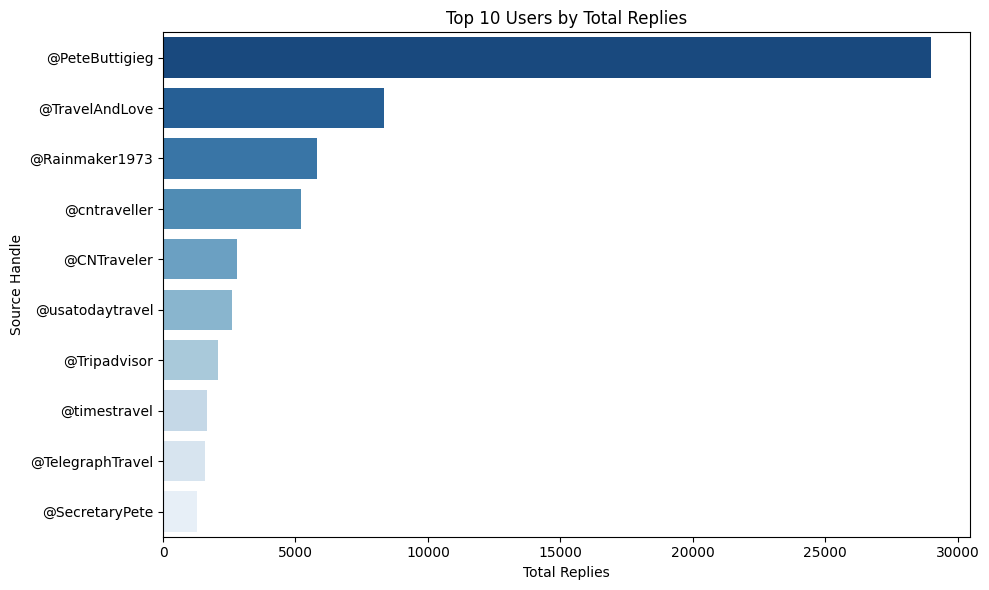

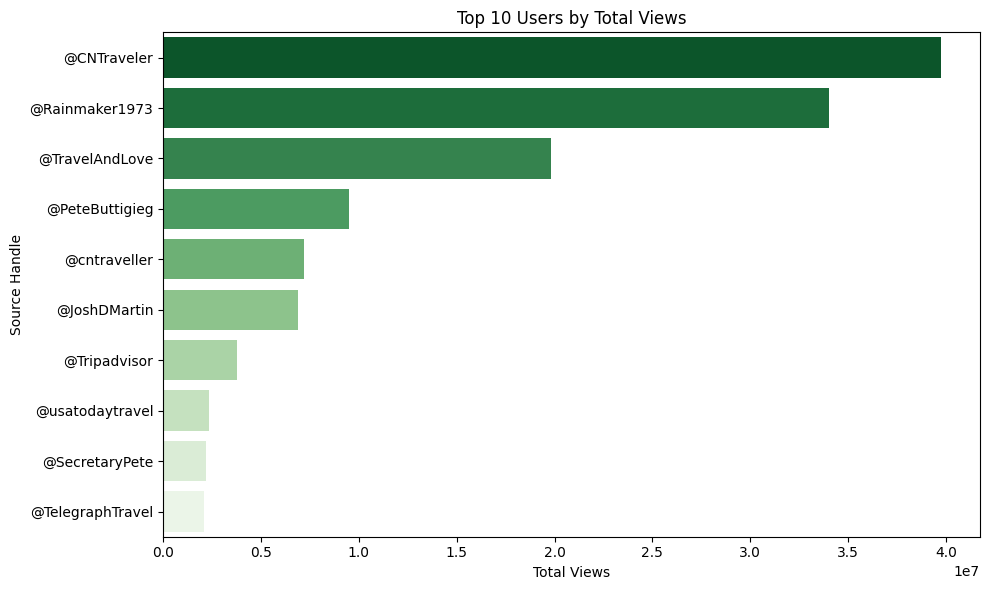

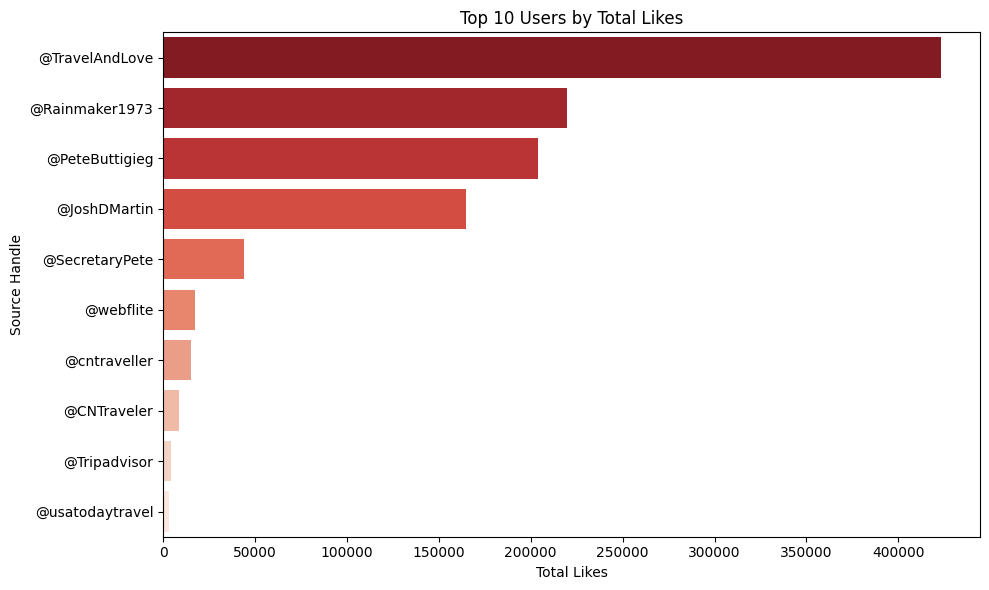

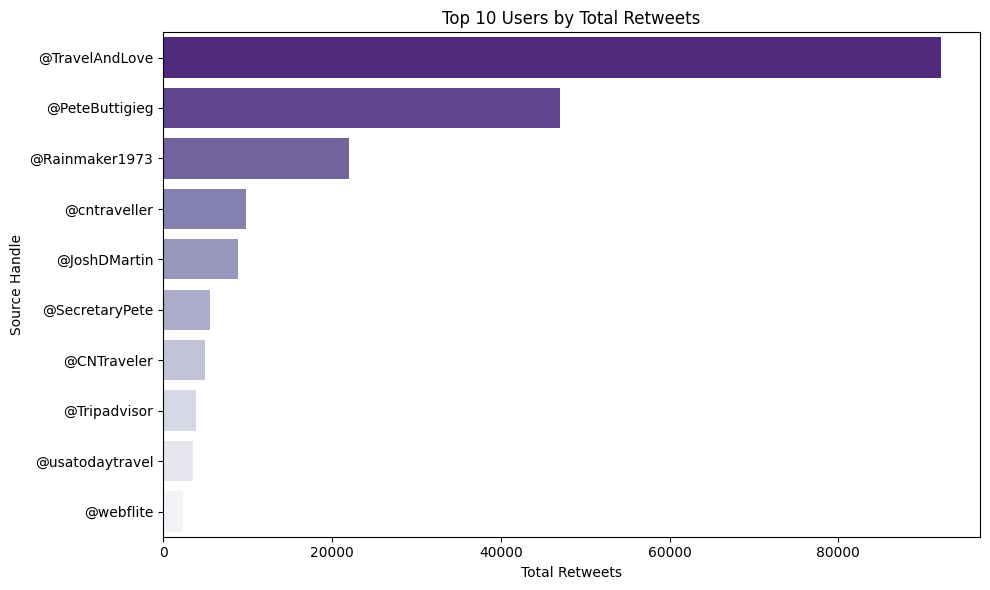

In [13]:
# Get the top 10 users by total engagement metrics
# Grouping and sorting
engagement_by_user = df_filtered.groupby('Source Handle')[['Replies', 'Views', 'Retweets', 'Likes']].sum()
top_replied_users = engagement_by_user.sort_values(by='Replies', ascending=False).head(10)
top_viewed_users = engagement_by_user.sort_values(by='Views', ascending=False).head(10)
top_liked_users = engagement_by_user.sort_values(by='Likes', ascending=False).head(10)
top_retweeted_users = engagement_by_user.sort_values(by='Retweets', ascending=False).head(10)

# Visualization
def plot_top_users(data, metric, color, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=data[metric].values, y=data.index, palette=color)
    plt.title(title)
    plt.xlabel(f'Total {metric}')
    plt.ylabel('Source Handle')
    plt.tight_layout()
    plt.show()

plot_top_users(top_replied_users, 'Replies', 'Blues_r', 'Top 10 Users by Total Replies')
plot_top_users(top_viewed_users, 'Views', 'Greens_r', 'Top 10 Users by Total Views')
plot_top_users(top_liked_users, 'Likes', 'Reds_r', 'Top 10 Users by Total Likes')
plot_top_users(top_retweeted_users, 'Retweets', 'Purples_r', 'Top 10 Users by Total Retweets')


### 5. Per-tweet engagement averages

Quality over Quantity: Accounts like @Rainmaker1973 and @PeteButtigieg prove that fewer, high-impact tweets outperform volume-driven strategies by traditional travel media.


Virality (e.g., @Rainmaker1973) win views.

Debatable Topics (e.g., @PeteButtigieg) drive replies.

Inspiration (e.g., @TravelAndLove) earns likes/shares.

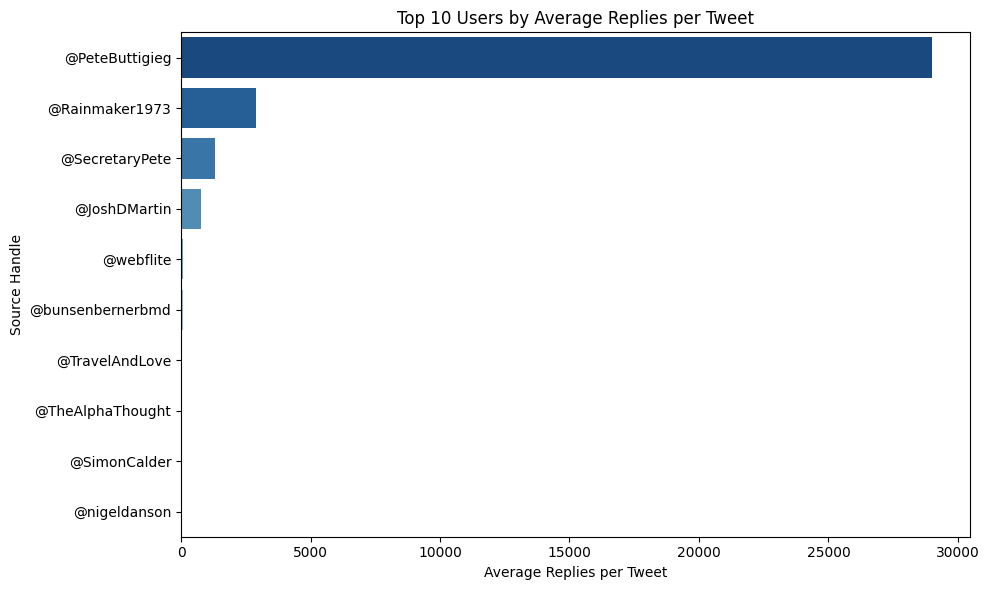

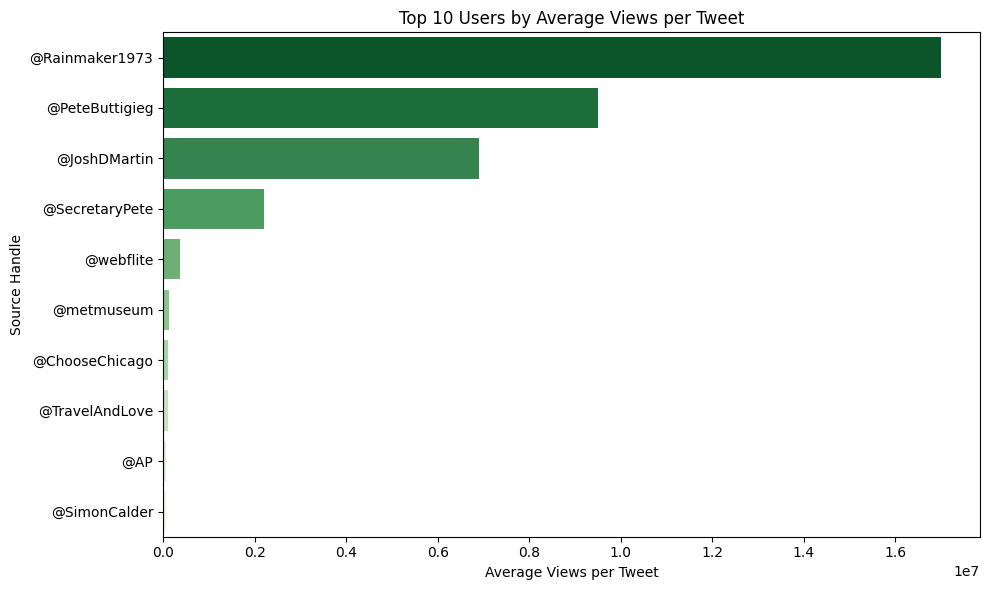

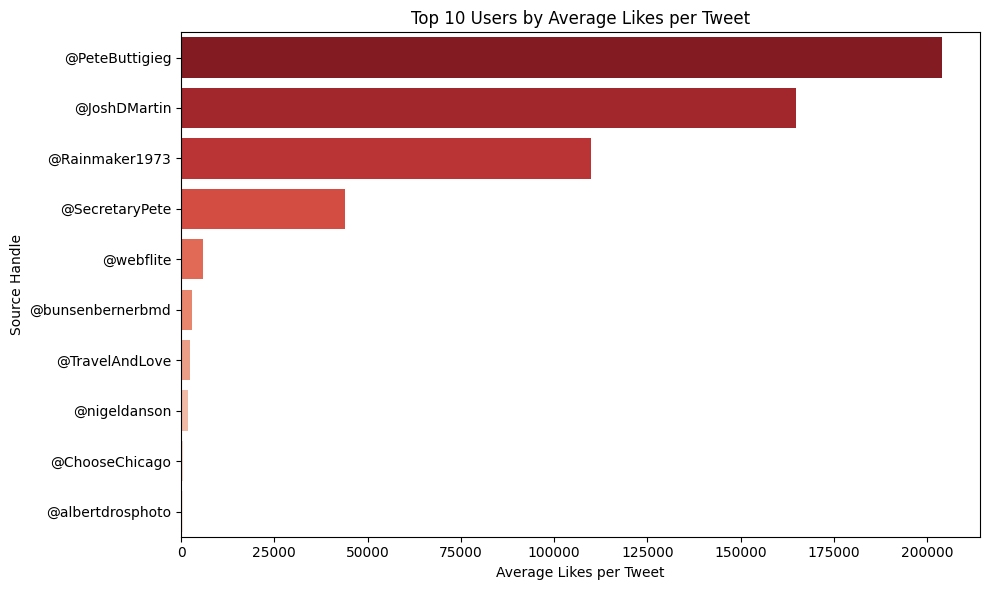

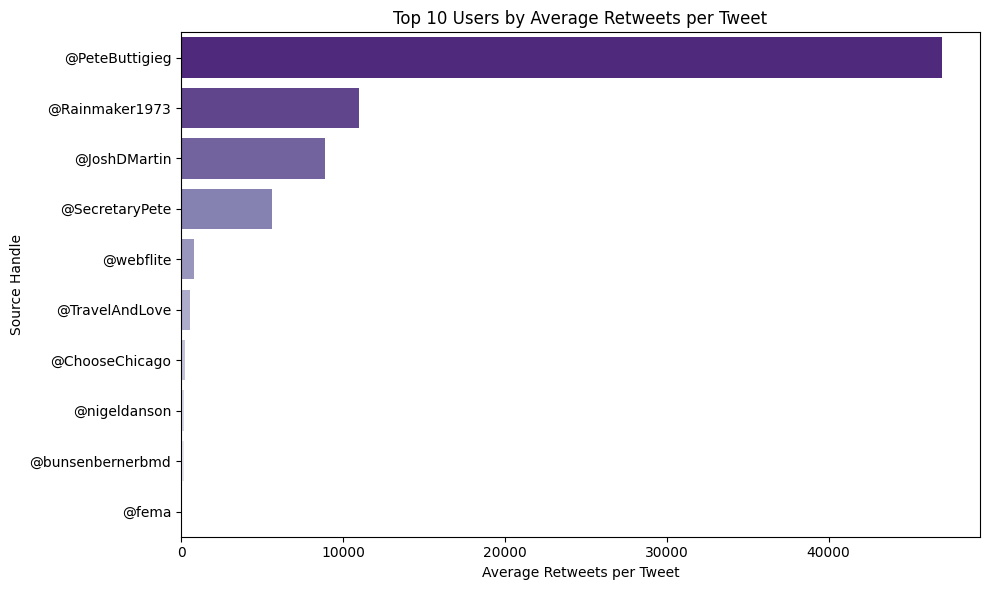

In [14]:
# Get the top 10 users by average engagement metrics
# Calculate total tweets per user
tweets_per_user = df_filtered.groupby('Source Handle').size()

# Calculate per-tweet averages for each user
engagement_per_tweet = engagement_by_user.div(tweets_per_user, axis=0)

# Get top 10 users by per-tweet likes, retweets, and views
top_per_tweet_replies = engagement_per_tweet.sort_values(by='Replies', ascending=False).head(10)
top_per_tweet_views = engagement_per_tweet.sort_values(by='Views', ascending=False).head(10)
top_per_tweet_likes = engagement_per_tweet.sort_values(by='Likes', ascending=False).head(10)
top_per_tweet_retweets = engagement_per_tweet.sort_values(by='Retweets', ascending=False).head(10)

# Visualization
def plot_per_tweet_engagement(data, metric, color, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=data[metric].values, y=data.index, palette=color)
    plt.title(title)
    plt.xlabel(f'Average {metric} per Tweet')
    plt.ylabel('Source Handle')
    plt.tight_layout()
    plt.show()

plot_per_tweet_engagement(top_per_tweet_replies, 'Replies', 'Blues_r', 'Top 10 Users by Average Replies per Tweet')
plot_per_tweet_engagement(top_per_tweet_views, 'Views', 'Greens_r', 'Top 10 Users by Average Views per Tweet')
plot_per_tweet_engagement(top_per_tweet_likes, 'Likes', 'Reds_r', 'Top 10 Users by Average Likes per Tweet')
plot_per_tweet_engagement(top_per_tweet_retweets, 'Retweets', 'Purples_r', 'Top 10 Users by Average Retweets per Tweet')


## B. LDA (Latent Dirichlet Allocation)

LDA assumes that topics are composed of multiple words. Separating these preprocessing steps allowed for finer control over what data was included.

For example, specific travel-related stop words were added uniquely for this analysis, because it led to more accurate and meaningful topics from the short tweets.

Memory usage was also improved in iterations, as processing a large dataset required experimenting with ways of optimizing the pipeline.


=== LDA ANALYSIS PIPELINE ===


Processing tweets: 100%|██████████| 10031/10031 [00:14<00:00, 698.24it/s]
2025-04-10 23:14:07,886 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-04-10 23:14:08,004 : INFO : adding document #10000 to Dictionary<10375 unique tokens: ['air', 'airline', 'boston', 'burger', 'come']...>
2025-04-10 23:14:08,004 : INFO : built Dictionary<10388 unique tokens: ['air', 'airline', 'boston', 'burger', 'come']...> from 10031 documents (total 85642 corpus positions)
2025-04-10 23:14:08,013 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<10388 unique tokens: ['air', 'airline', 'boston', 'burger', 'come']...> from 10031 documents (total 85642 corpus positions)", 'datetime': '2025-04-10T23:14:08.013624', 'gensim': '4.3.3', 'python': '3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
2025-04-10 23:14:08,017 : INFO : discarding 7600 tokens: [('initial', 3), ('lik'


=== Topic Word Distributions ===

Topic 0:
0.026*"city" + 0.017*"hotel" + 0.011*"stay" + 0.011*"pool" + 0.011*"view" + 0.010*"head" + 0.010*"european" + 0.010*"europe" + 0.010*"favourite" + 0.010*"beach"

Topic 1:
0.035*"park" + 0.030*"new" + 0.018*"more" + 0.017*"national" + 0.017*"universal" + 0.015*"week" + 0.015*"vermont" + 0.015*"maui" + 0.014*"batter" + 0.014*"state"

Topic 2:
0.024*"dog" + 0.021*"list" + 0.019*"beach" + 0.015*"disease" + 0.015*"bucket" + 0.013*"italy" + 0.012*"passport" + 0.012*"coast" + 0.012*"item" + 0.011*"east"

Topic 3:
0.029*"damage" + 0.022*"flight" + 0.020*"cruise" + 0.017*"cause" + 0.016*"ceo" + 0.015*"people" + 0.015*"kill" + 0.015*"universe" + 0.014*"kelly" + 0.014*"suffer"

Topic 4:
0.039*"world" + 0.023*"place" + 0.018*"good" + 0.017*"destination" + 0.015*"city" + 0.014*"top" + 0.014*"harry" + 0.014*"effect" + 0.014*"new" + 0.014*"potter"

=== Top Terms Per Topic ===


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,city,park,dog,damage,world
1,hotel,new,list,flight,place
2,stay,more,beach,cruise,good
3,pool,national,disease,cause,destination
4,view,universal,bucket,ceo,city
5,head,week,italy,people,top
6,european,vermont,passport,kill,harry
7,europe,maui,coast,universe,effect
8,favourite,batter,item,kelly,new
9,beach,state,east,suffer,potter


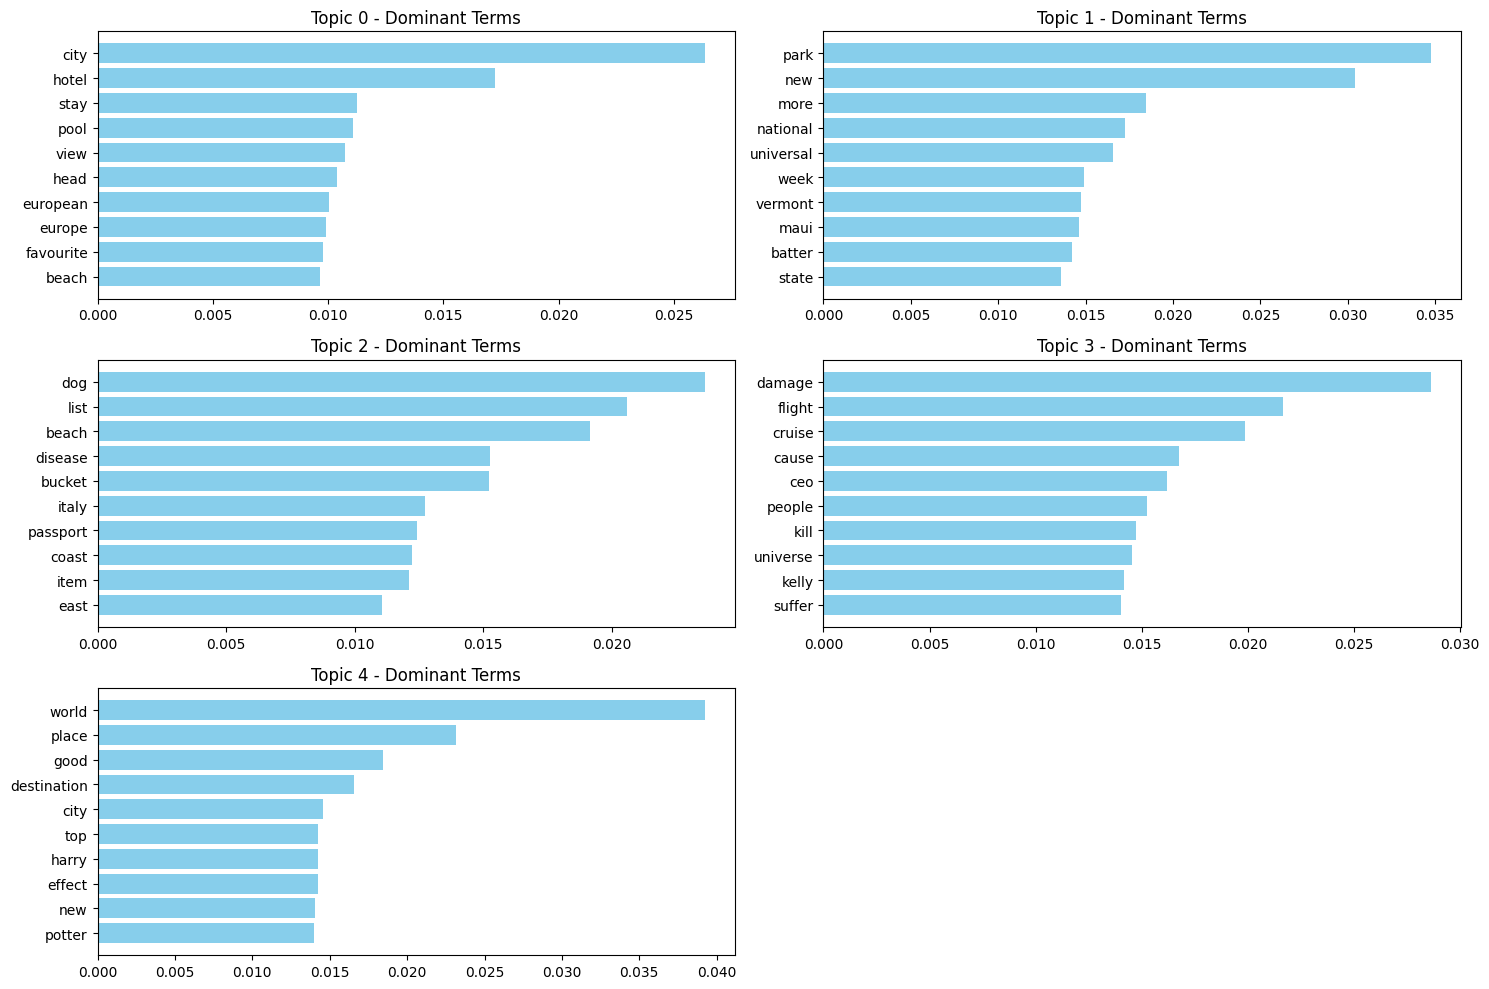


Generating interactive topic visualization...
Saved pyLDAvis to 'lda_visualization.html'

=== Sample Tweets for Each Topic ===

Topic 0 - Characteristic Tweets:
1. for a complete reboot of mind body and soul head for some topnotch rejuvenation from fitness breaks at stately homes to meditation and wild camping on the moors
2. seaside spots along the cirque terre and the amalfi coast have long pulled in visitors but there are plenty of other lesscrowded towns to choose from turmoil with its medieval castle to the tiny island of levanzo
3. our editors across the globe share the best cruise ships

Topic 1 - Characteristic Tweets:
1. pop you listened when we told you to visit acacia national park to watch the leaves change
2. new issue alert
3. yes you should plan a whole trip to the pacific northwest just to go blueberry picking

Topic 2 - Characteristic Tweets:
1. exploring the quieter side of the cycles on a greek island hopping holiday
2. majors major mountain range is every bit as be

Analyzing topics: 100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


Saved topic trends visualization to 'lda_topic_trends_over_time.html'

Saving comprehensive LDA results to CSV...
Saved complete results to lda_results.csv

LDA analysis complete. Results saved to:
- lda_visualization.html (interactive topics)
- lda_results.csv (complete analysis)
- lda_topic_trends_over_time.html (trends)


In [15]:
"""
LDA Topic Modeling Pipeline

This script performs LDA topic modeling on travel-related tweets, including:
- Text preprocessing (tokenization, lemmatization, stopword removal)
- Dictionary and corpus creation
- LDA model training
- Visualization and analysis
- Trend analysis over time

Key Components:
1. Text preprocessing with spaCy
2. Gensim for LDA implementation
3. pyLDAvis for interactive visualization
4. Plotly for trend visualizations
"""

import spacy
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import plotly.express as px
from collections import Counter
from gensim import corpora
from gensim.models import LdaModel
import logging
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess

# Initialize spaCy with optimized settings
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Define travel-specific parameters
TRAVEL_KEEP_POS = {"NOUN", "VERB", "ADJ", "PROPN"}  # Parts of speech to keep

# Custom stopwords for travel domain:
# Tweaked based on previous iterations,it lead more accurate and meaningful topics from the short tweets.
TRAVEL_STOPWORDS = {  
    'travel', 'trip', 'vacation', 'journey', 'go', 'visit', 'see', 'book', 'fly',
    'here', 'know', 'like', 'get', 'one', 'time', 'make', 'take', 'want'
}

# Setup logging for better tracking and error handling
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

def process_travel_tweets(df, text_col="Cleaned Tweet", max_docs=None):
    """
    Roboust method to clean and process travel tweets with optimized memory management.
    
    Performs:
    - Tokenization using spaCy
    - Lemmatization
    - POS filtering
    - Custom stopword removal
    - Length filtering
    
    Args:
        df (pd.DataFrame): Input dataframe containing previously pre-processed tweets
        text_col (str): Column name containing text to process
        max_docs (int): Maximum number of documents to process (None for all)
    
    Returns:
        pd.DataFrame: DataFrame with added 'Processed_Tokens' column
    
    Customization Points:
        - TRAVEL_KEEP_POS: Change POS tags to keep
        - TRAVEL_STOPWORDS: Add/remove domain-specific stopwords
        - max_docs: Adjust for memory constraints
    """
    if max_docs:
        df = df.iloc[:max_docs].copy()
    
    texts = df[text_col].astype(str).tolist()
    
    # Process texts in batches for memory efficiency
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=1000), total=len(texts), desc="Processing tweets"):
        tokens = [
            token.lemma_.lower() for token in doc
            if (token.pos_ in TRAVEL_KEEP_POS and 
                token.lemma_.lower() not in TRAVEL_STOPWORDS and
                len(token.lemma_) > 2)
        ]
        processed_texts.append(tokens)
    
    df['Processed_Tokens'] = processed_texts
    return df

def train_lda_model(df, num_topics=5, max_docs=None):
    """
    Train LDA model on processed tweets with memory-efficient settings.
    
    Steps:
    1. Creates dictionary from processed tokens
    2. Filters extreme values
    3. Creates bag-of-words corpus
    4. Trains LDA model
    
    Args:
        df (pd.DataFrame): Processed dataframe from process_travel_tweets()
        num_topics (int): Number of topics to extract
        max_docs (int): Maximum documents to use (None for all)
    
    Returns:
        tuple: (lda_model, corpus, id2word dictionary)
    
    Tunable Parameters:
        - num_topics: Ideal range 3-15 depending on dataset size
        - no_below/no_above: Dictionary filtering thresholds
        - chunksize: Adjust based on available RAM
        - passes/iterations: Control training duration/quality
    """
    if max_docs:
        df = df.iloc[:max_docs].copy()
    
    # Create and filter dictionary
    id2word = corpora.Dictionary(df['Processed_Tokens'])
    id2word.filter_extremes(no_below=5, no_above=0.5)
    logger.info(f"Dictionary size: {len(id2word)}")
    
    # Create corpus as list 
    corpus = [id2word.doc2bow(tokens) for tokens in df['Processed_Tokens']]
    
    # Train LDA with memory-efficient settings
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        chunksize=1000,
        passes=2,
        iterations=50,
        alpha='auto',
        eta='auto',
        eval_every=None,
        random_state=42
    )
    
    return lda_model, corpus, id2word

def visualize_topics(lda_model, corpus, id2word):
    """
    Generate interactive pyLDAvis visualization of topics.
    
    Args:
        lda_model: Trained LDA model
        corpus: Processed bag-of-words corpus
        id2word: Gensim dictionary
    
    Returns:
        Prepared pyLDAvis visualization object
    """
    vis = gensimvis.prepare(lda_model, corpus, id2word)
    pyLDAvis.display(vis)
    return vis

def visualize_topics_enhanced(lda_model, num_words=10):
    """
    Create enhanced visualizations of topics including:
    - DataFrame of top terms
    - Horizontal bar charts
    - Styled table output
    
    Args:
        lda_model: Trained LDA model
        num_words: Number of top words to show per topic
    """
    # Create DataFrame of topic words
    topic_words = []
    for topic_id in range(lda_model.num_topics):
        words = lda_model.show_topic(topic_id, topn=num_words)
        topic_words.append([word[0] for word in words])
    
    topic_df = pd.DataFrame(topic_words).T
    topic_df.columns = [f'Topic {i}' for i in range(lda_model.num_topics)]
    
    # Print table
    print("\n=== Top Terms Per Topic ===")
    display(topic_df.style.background_gradient(cmap='Blues'))
    
    # Create bar charts for each topic
    plt.figure(figsize=(15, 10))
    for i in range(lda_model.num_topics):
        plt.subplot(3, 2, i+1)
        topic = lda_model.show_topic(i, num_words)
        words = [word[0] for word in topic]
        weights = [word[1] for word in topic]
        
        plt.barh(words, weights, color='skyblue')
        plt.title(f'Topic {i} - Dominant Terms')
        plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def get_topic_samples(df, lda_model, id2word, n_samples=3):
    """
    Get representative sample tweets for each topic.
    
    Args:
        df: Processed DataFrame with tweets
        lda_model: Trained LDA model
        id2word: Gensim dictionary
        n_samples: Number of samples per topic
    
    Returns:
        dict: {topic_id: [sample_tweets]}
    """
    
    df['topic_probs'] = df['Processed_Tokens'].apply(
        lambda x: dict(lda_model.get_document_topics(id2word.doc2bow(x))))
    
    df['dominant_topic'] = df['topic_probs'].apply(
        lambda x: max(x.items(), key=lambda item: item[1])[0] if x else -1)
    
    # Get samples for each topic
    samples = {}
    for topic in range(lda_model.num_topics):
        topic_tweets = df[df['dominant_topic'] == topic]
        samples[topic] = topic_tweets.sample(
            min(n_samples, len(topic_tweets)))['Cleaned Tweet'].tolist()
    
    return samples

def analyze_topic_trends(df, lda_model, id2word):
    """
    Analyze topic trends over time with memory-efficient processing.
    
    Args:
        df: Processed DataFrame with datetime info
        lda_model: Trained LDA model
        id2word: Gensim dictionary
    
    Returns:
        pd.DataFrame: Topic trends with columns [date, topic_id, probability]
    """
    topic_data = []
    
    # Process in chunks for memory efficiency
    chunk_size = 1000
    for i in tqdm(range(0, len(df), chunk_size), desc="Analyzing topics"):
        chunk = df.iloc[i:i+chunk_size]
        for _, row in chunk.iterrows():
            bow = id2word.doc2bow(row['Processed_Tokens'])
            topic_dist = lda_model.get_document_topics(bow)
            for topic_id, prob in topic_dist:
                topic_data.append({
                    'date': row['Tweet Datetime Posted'].date(),
                    'topic_id': topic_id,
                    'probability': prob
                })
    
    return pd.DataFrame(topic_data)

def visualize_topic_trends(trend_df):
    """
    Visualize topic trends over time using Plotly.
    
    Args:
        trend_df: DataFrame from analyze_topic_trends()
    
    Returns:
        plotly Figure object
    """
    # Aggregate probabilities by date and topic
    trend_agg = trend_df.groupby(['date', 'topic_id'])['probability'].mean().reset_index()
    
    # Create interactive plot
    fig = px.line(trend_agg, 
                 x='date', 
                 y='probability',
                 color='topic_id',
                 title='Topic Trends Over Time',
                 labels={'probability': 'Average Topic Probability', 'date': 'Date'},
                 template='plotly_white')
    
    fig.update_layout(hovermode='x unified')
    return fig


if __name__ == "__main__":
    """
    Main execution pipeline for travel tweet topic modeling.
    
    Steps:
    1. Preprocess tweets
    2. Train LDA model
    3. Generate visualizations
    4. Save results
    """
    try:
        print("\n=== LDA ANALYSIS PIPELINE ===")
        # Process tweets in batches
        df_processed = process_travel_tweets(df_filtered, max_docs=11000)
        
        # Train LDA model
        lda_model, corpus, id2word = train_lda_model(df_processed, num_topics=5)
        
        # Print topic words
        print("\n=== Topic Word Distributions ===")
        for idx, topic in lda_model.print_topics(-1):
            print(f"\nTopic {idx}:\n{topic}")
        
        # Create enhanced visualizations
        visualize_topics_enhanced(lda_model)
        
        # Generate interactive visualization
        print("\nGenerating interactive topic visualization...")
        vis = gensimvis.prepare(lda_model, corpus, id2word)
        pyLDAvis.save_html(vis, 'lda_visualization.html')
        print("Saved pyLDAvis to 'lda_visualization.html'")
        
        # Get sample tweets per topic
        topic_samples = get_topic_samples(df_processed, lda_model, id2word)
        print("\n=== Sample Tweets for Each Topic ===")
        for topic, samples in topic_samples.items():
            print(f"\nTopic {topic} - Characteristic Tweets:")
            for i, tweet in enumerate(samples, 1):
                print(f"{i}. {tweet}")

        # Analyze and visualize topic trends
        print("\nAnalyzing topic trends over time...")
        topic_trends = analyze_topic_trends(df_processed, lda_model, id2word)
        trend_fig = visualize_topic_trends(topic_trends)
        
        # Save trend visualization
        trend_fig.write_html("lda_topic_trends_over_time.html")
        print("Saved topic trends visualization to 'lda_topic_trends_over_time.html'")
                
        # Save comprehensive results
        print("\nSaving comprehensive LDA results to CSV...")
        output_df = df_processed.copy()
        output_df['topic_prob'] = output_df.apply(
            lambda row: row['topic_probs'].get(row['dominant_topic'], 0), axis=1)
        
        for topic_id in range(lda_model.num_topics):
            output_df[f"topic_{topic_id}_prob"] = df_processed['topic_probs'].apply(
                lambda x: x.get(topic_id, 0))
        
        output_df.to_csv("lda_results.csv", index=False)
        print("Saved complete results to lda_results.csv")

    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        
    finally:
        # Clean up large objects
        if 'df_processed' in locals():
            del df_processed
        if 'corpus' in locals():
            del corpus
        import gc
        gc.collect()

    print("\nLDA analysis complete. Results saved to:")
    print("- lda_visualization.html (interactive topics)")
    print("- lda_results.csv (complete analysis)")
    print("- lda_topic_trends_over_time.html (trends)")

## C. BERTweet

Careful cleaning and preprocessing were essential with BERTopic and BERTweet embeddings. Aggressive preprocessing initially led to unproductive results, but after fine-tuning stop words and vectorizer settings, valuable insights emerged.

Initially, 60+ topics were suggested with a good silhouette score, but these were reduced to under 20, prioritizing topic interpretability over strict clustering metrics.

In [ ]:
"""
BERTopic Analysis Pipeline 

This script performs advanced topic modeling using BERTopic, including:
- Text cleaning and preprocessing
- BERTweet embeddings generation
- Dynamic topic modeling with BERTopic
- Visualization
- Trend analysis over time

Key Components:
1. Text preprocessing with spaCy
2. BERTweet embeddings generation
3. BERTopic for dynamic topic modeling
"""

import numpy as np
import pandas as pd
import re
import spacy
import torch
import gc
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import normalize
from bertopic import BERTopic
import pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer
import warnings
import plotly.express as px
from datetime import datetime
import logging

# Setup logging for better tracking and error handling
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Configuration
MAX_BATCH_SIZE = 3000  # Max texts per preprocessing batch for memory efficiency
EMBEDDING_BATCH_SIZE = 32  # Batch size for embedding generation

# Initialize spaCy with optimized settings
print("Loading NLP models...")
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "tagger"]) 

# Parts of speech to keep
TRAVEL_KEEP_POS = {"NOUN", "VERB", "ADJ", "PROPN", "ADV", "DET", "PRON"}

# Custom stopwords for travel domain, tweaked based on previous iterations
TRAVEL_STOPWORDS = set([
    "the", "a", "an", "and", "in", "on", "for", "to", "with", "at", "by", "of", 
    "from", "as", "it", "is", "that", "this", "you", "are", "i", "be", "have"
])

def clean_text(text):
    """
    Roboust method to clean travel tweets.
    
    Performs:
    - Removing URLs, mentions, hashtags
    - Removing special characters
    - Normalizing whitespace
    - Converting to lowercase
    
    Args:
        text (str): Input containing previously pre-processed tweets. 
        
    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', '', text)  # Remove URLs/mentions
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove special chars
    return re.sub(r'\s+', ' ', text).strip().lower()  # Normalize whitespace

def preprocess_batch(texts):
    """
    Process batch of tweets with spaCy pipeline with memory-efficient settings.

    Performs:
    - Tokenization
    - Lemmatization
    - Stopword removal
    - POS filtering
    
    Args:
        texts (list): List of raw text strings
        
    Returns:
        list: List of processed text strings
    """
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=1000):
        tokens = [token.lemma_.lower() for token in doc 
                 if token.lemma_.lower() not in TRAVEL_STOPWORDS]
        processed_texts.append(" ".join(tokens) if tokens else "")
    return processed_texts


class EmbeddingGenerator:
    """
    BERTweet Embedding Generator.
    
    Performs:
    - Model loading
    - Batch processing
    - GPU utilization
    - Embedding normalization
    """
    
    def __init__(self):
        """Initialize BERTweet model and tokenizer"""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"  • Using device: {self.device}")
        print("  • Loading BERTweet model...")
        self.tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
        self.model = AutoModel.from_pretrained("vinai/bertweet-base").to(self.device).eval()
        print("  • Model loaded successfully")

    def generate_embeddings(self, texts):
        """
        Generate BERTweet embeddings for input texts
        
        Args:
            texts (list): List of preprocessed text strings
            
        Returns:
            numpy.ndarray: Normalized embeddings matrix
        """
        embeddings = []
        logging.info(f"  • Generating embeddings for {len(texts)} texts...")
        
        for i in tqdm(range(0, len(texts), EMBEDDING_BATCH_SIZE), 
                    desc="Generating Embeddings", unit="batch"):
            batch = texts[i:i + EMBEDDING_BATCH_SIZE]
            with torch.no_grad():
                inputs = self.tokenizer(
                    batch, 
                    return_tensors="pt",
                    truncation=True,
                    padding=True,
                    max_length=64
                ).to(self.device)
                outputs = self.model(**inputs)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_embeddings)
            torch.cuda.empty_cache()
        
        if not embeddings:
            return np.array([])
        
        # Stack all embeddings into a 2D array
        all_embeddings = np.vstack(embeddings)
        
        # Normalize embeddings
        if all_embeddings.size > 0:
            try:
                print("  • Normalizing embeddings...")
                return normalize(all_embeddings, axis=1)
            except ValueError as e:
                print(f"  • Normalization error: {e}")
                print(f"  • Array shape: {all_embeddings.shape}")
                return all_embeddings
        return all_embeddings

def analyze_with_bertopic(texts, embeddings):
    """
    Perform BERTopic analysis with enhanced settings.
    
    Steps:
    1. Initialize BERTopic with custom parameters
    2. Fit model to embeddings
    3. Reduce and refine topics
    4. Generate visualizations
    
    Args:
        texts (list): Processed text strings
        embeddings (np.ndarray): Corresponding embeddings
        
    Returns:
        tuple: (BERTopic model, topic assignments)
    """
    logging.info("\n Analyzing topics with BERTopic...")
    
    # Initialize with custom parameters
    logging.info("  • Configuring BERTopic model...")
    # Vectorizer settings
    vectorizer_model = CountVectorizer(
        stop_words="english",
        min_df=5,      # Ignore rare terms
        max_df=0.9,     # Ignore overly common terms
        ngram_range=(1, 2)  # Include bigrams
    )
    
    topic_model = BERTopic(
        embedding_model=None,  # Using pre-computed embeddings
        vectorizer_model=vectorizer_model,
        min_topic_size=50,     # Minimum tweets per topic
        nr_topics="auto",      # Automatic topic count
        verbose=True
    )
    
    # Fit the model
    logging.info("  • Fitting model to embeddings...")
    topics, probs = topic_model.fit_transform(texts, embeddings)

    # Reduce topics
    logging.info("\n Refining topics...")
    logging.info("  • Reducing to ~20 key topics...")
    topic_model.reduce_topics(texts, nr_topics=20)
    updated_topics = topic_model.topics_

    # Dynamic labeling
    logging.info("  • Updating topic labels with bigrams...")
    topic_model.update_topics(texts, n_gram_range=(1, 2))

    # Show topic info
    logging.info("\n=== TOPIC SUMMARY ===")
    topic_info = topic_model.get_topic_info()
    print(topic_info.head(10))

    # Visualize Topic Landscape
    fig_topics = topic_model.visualize_topics()
    fig_topics.write_html("bertopic_visualization.html")
    print("  • Topic visualization saved to bertopic_visualization.html")

    # Visualize Topic Frequency Barchart
    fig_barchart = topic_model.visualize_barchart()
    fig_barchart.show()

    # Visualize Hierarchical Topic Tree
    fig_hierarchy = topic_model.visualize_hierarchy()
    fig_hierarchy.show()  
    
    return topic_model, updated_topics

def process_tweets(tweet_texts, original_df=None):
    """
    Complete tweet processing pipeline with datetime preservation.
    
    Args:
        tweet_texts (list): Pre-processed tweet texts
        original_df (pd.DataFrame): Original DataFrame containing metadata
                
    Returns:
        tuple: (results DataFrame, BERTopic model)
    """
    # Text cleaning
    logging.info("\n Cleaning and preprocessing tweets...")
    cleaned_texts = [clean_text(t) for t in tweet_texts]
    
    # Batch processing
    processed_texts = []
    for i in tqdm(range(0, len(cleaned_texts), MAX_BATCH_SIZE), 
              desc="Preprocessing", unit="batch"):
        batch = cleaned_texts[i:i + MAX_BATCH_SIZE]
        processed_texts.extend(preprocess_batch(batch))
    
    # Filter empty texts and preserve original indices
    valid_indices = [i for i, text in enumerate(processed_texts) if text.strip()]
    processed_texts = [processed_texts[i] for i in valid_indices]
    tweet_texts = [tweet_texts[i] for i in valid_indices]
    
    # Create results DataFrame with datetime if available
    result_data = {
        'Cleaned Tweet': tweet_texts,
        'Processed Tweet': processed_texts,
        'Topic': None  # Will be filled after BERTopic
    }
    
    # Add datetime from original DataFrame if available
    if original_df is not None and 'Tweet Datetime Posted' in original_df.columns:
        result_data['Tweet Datetime Posted'] = original_df.iloc[valid_indices]['Tweet Datetime Posted'].values
    
    df = pd.DataFrame(result_data)
    
    # Embedding generation
    logging.info("\n Generating BERTweet embeddings...")
    embedder = EmbeddingGenerator()
    embeddings = embedder.generate_embeddings(processed_texts)
    del embedder
    gc.collect()

    # BERTopic analysis
    topic_model, topics = analyze_with_bertopic(processed_texts, embeddings)
    df['Topic'] = topics  # Add topics to DataFrame
    
    df.to_csv("bertopic_results.csv", index=False)
    return df, topic_model
    

if __name__ == "__main__":
    """
    Main execution pipeline for travel tweet topic modeling.
    """
    tweet_texts = df_filtered["Cleaned Tweet"].astype(str).tolist()
   
    try:
        print("\n=== BERTOPIC ANALYSIS PIPELINE ===")
        df_result, topic_model = process_tweets(tweet_texts, original_df=df_filtered)
        
        # Save the model and results for the next notebook
        topic_model.save("bertopic_model")
        df_result.to_pickle("bertopic_results.pkl")
        
        print("\nBERTopic analysis complete. Results saved to:")
        print("- bertopic_model (BERTopic model)")
        print("- bertopic_results.pkl (processed results)")
        print("- bertopic_visualization.html (interactive topics)")
        print("- bertopic_results.csv (complete analysis)")
        
    except Exception as e:
        print(f"\n=== ERROR ===")
        print(f"Pipeline failed: {str(e)}")
    finally:
        # Cleanup
        torch.cuda.empty_cache()
        gc.collect()

Loading NLP models...


2025-04-10 23:14:26,749 : INFO : 
 Cleaning and preprocessing tweets...



=== BERTOPIC ANALYSIS PIPELINE ===


Preprocessing:   0%|          | 0/4 [00:00<?, ?batch/s]

2025-04-10 23:14:37,105 : INFO : 
 Generating BERTweet embeddings...


  • Using device: cpu
  • Loading BERTweet model...


2025-04-10 23:14:40,333 : INFO :   • Generating embeddings for 10013 texts...


  • Model loaded successfully


Generating Embeddings:   0%|          | 0/313 [00:00<?, ?batch/s]

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from bertopic import BERTopic

# Load the saved model and results
print("Loading saved model and results...")
topic_model = BERTopic.load("bertopic_model")
df_result = pd.read_pickle("bertopic_results.pkl")

# Sample Tweets
def visualize_topics_with_examples(topic_model, df_results):
    # Get topic info
    topic_info = topic_model.get_topic_info()
    
    # Create a styled DataFrame for display
    display_df = topic_info[['Topic', 'Count', 'Name']].copy()
    display_df['Sample Tweet'] = ""
    
    # Get sample tweets for each topic
    for topic in display_df['Topic']:
        if topic != -1:  # Skip noise topic
            topic_tweets = df_results[df_results['Topic'] == topic]
            sample_size = min(3, len(topic_tweets))
            sample_tweets = topic_tweets['Cleaned Tweet'].sample(sample_size)
            display_df.loc[display_df['Topic'] == topic, 'Sample Tweet'] = "<br>• " + "<br>• ".join(sample_tweets)
    
    # Create standalone bar chart
    bar_chart = go.Figure(
        data=[go.Bar(x=display_df['Name'], y=display_df['Count'], marker_color=px.colors.qualitative.Plotly)],
        layout=go.Layout(
            title="Topic Distribution",
            xaxis=dict(title="Topic Name"),
            yaxis=dict(title="Tweet Count"),
            height=600
        )
    )

    # Create standalone table with sample tweets
    table = go.Figure(
        data=[go.Table(
            header=dict(
                values=['Topic', 'Name', 'Sample Tweet'], 
                align='left'
            ),
            cells=dict(
                values=[display_df['Topic'], display_df['Name'], display_df['Sample Tweet']],
                align='left', 
                height=40
            ),
            columnwidth=[0.1, 0.2, 0.7]  # Adjust column widths: Topic is smaller, Name a bit smaller, Sample Tweet bigger
        )],
        layout=go.Layout(
            title="Topic Details with Sample Tweets",
            height=800
        )
    )

    return bar_chart, table

#Timeline of Topics with News Events
def create_topic_timeline(df_result):
    # Ensure 'Tweet Datetime Posted' exists in df_result by copying from df_filtered
    if 'Tweet Datetime Posted' not in df_result.columns:
        df_result['Tweet Datetime Posted'] = df_result['Tweet Datetime Posted'].copy()

    if 'Tweet Datetime Posted' in df_result.columns and df_result['Tweet Datetime Posted'].notnull().any():
        try:
            # Convert to datetime and extract month-year
            df_result['date'] = pd.to_datetime(df_result['Tweet Datetime Posted']).dt.to_period('M').dt.to_timestamp()

            # Group by month and topic
            topic_trends = df_result.groupby(['date', 'Topic']).size().reset_index(name='count')

            # Normalize to get percentage/probability
            total_tweets = topic_trends.groupby('date')['count'].transform('sum')
            topic_trends['probability'] = topic_trends['count'] / total_tweets

            # Remove invalid topics (e.g., topic -1 for noise)
            topic_trends = topic_trends[topic_trends['Topic'] != -1]

            # Create interactive line plot for topic trends
            fig = px.line(
                topic_trends,
                x='date',
                y='probability',
                color='Topic',
                title='Topic Trends Over Time',
                labels={'probability': 'Percentage of Tweets', 'Topic': 'Topic ID'},
                hover_data={'Topic': True, 'probability': ':.2f', 'count': True},
                width=1000,
                height=600
            )

            # Layout tweaks
            fig.update_layout(
                xaxis_title='Date',
                yaxis_title='Percentage of Tweets',
                hovermode='x unified',
                legend_title_text='Topic ID'
            )

            # Optional annotation 
            #if len(topic_trends['date'].unique()) > 6:
            #    fig.add_annotation(
            #        x=topic_trends['date'].median(),
            #        y=topic_trends['probability'].max() * 0.9,
            #        text="Peak Discussion Period",
            #        showarrow=True,
            #        arrowhead=1
            #    )

            # Save the figure as HTML
            fig.write_html("bertopic_trends_over_time.html")
            
            return fig

        except Exception as e:
            print(f"Could not create trends visualization: {str(e)}")
    else:
        print("No valid datetime information available for trend analysis")
        return None

# Run visualizations
print("Creating visualizations...")
topic_viz_bar, topic_viz_table = visualize_topics_with_examples(topic_model, df_result)
timeline_viz = create_topic_timeline(df_result)

# Display results
print("Displaying results...")
topic_viz_bar.show()
topic_viz_table.show()
if timeline_viz is not None:  # Only show if timeline was created
    timeline_viz.show()

print("BERTopic visualization complete.")
print("Results saved to: bertopic_trends_over_time.html")